In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys
sys.path.append('..')

import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

In [3]:
import logging
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

import py21cmfast as p21c
from py21cmfast import plotting, cache_tools

print(f'Using 21cmFAST version {p21c.__version__}')
#p21c.config['direc'] = '/scratch/submit/ctp/yitians/21cmFAST-cache'
p21c.global_params.ZPRIME_STEP_FACTOR= 1.05


Using 21cmFAST version 0.1.dev1577+ga2f53fc.d20230210


In [7]:
#from dm21cm.common import get_circle_seq_at

def get_circle(size=None):
    im = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            if (i-size/2-1/2)**2 + (j-size/2-1/2)**2 < (0.3*size)**2:
                im[i,j] = 1
    return im

def get_circle_seq_at(size, n_per_side, at_i):
    bs = int(np.floor(size/n_per_side))
    at_i = at_i % n_per_side**2
    i = at_i // n_per_side
    j = at_i %  n_per_side
    im = np.zeros((size,size))
    im[i*bs:(i+1)*bs, j*bs:(j+1)*bs] = get_circle(size=bs)
    return np.einsum('i,jk->ijk', np.ones((size,)), im)

## 1. Test run

In [8]:
cache_tools.clear_cache()

2023-02-18 09:29:26,822 | INFO | Removing InitialConditions_2eda6b944366038a89d6590f0449374d_r54321.h5
2023-02-18 09:29:26,823 | INFO | Removed 1 files from cache.


In [9]:
# initialize
initial_conditions = p21c.initial_conditions(
    user_params = {"HII_DIM": 50, "BOX_LEN": 50},
    cosmo_params = p21c.CosmoParams(SIGMA_8=0.8),
    random_seed=54321, write=True
)

# redshift
end_z = 20 # set some low threshold
rs_arr = [end_z]

while np.amax(rs_arr) < p21c.global_params.Z_HEAT_MAX:
    prev_z = (1 + np.amax(rs_arr)) * p21c.global_params.ZPRIME_STEP_FACTOR - 1
    rs_arr.append(prev_z)
    
rs_arr = rs_arr[::-1][1:][:10] # only do 10 steps

In [10]:
Tk_box_arr = []

for i_rs, rs in enumerate(rs_arr):
    
    print(f'i_rs={i_rs} rs={rs:.3f}')
    
    # input
    input_heating = p21c.input_heating(redshift=rs, init_boxes=initial_conditions, write=False)
    input_ionization = p21c.input_ionization(redshift=rs, init_boxes=initial_conditions, write=False)
    input_jalpha = p21c.input_jalpha(redshift=rs, init_boxes=initial_conditions, write=False)

    input_heating.input_heating += get_circle_seq_at(50, 3, i_rs)
    input_ionization.input_ionization += get_circle_seq_at(50, 5, 9-i_rs) * 1e-3
    
    # perturbed_field to control redshift
    perturbed_field = p21c.perturb_field(redshift=rs, init_boxes=initial_conditions)
    
    # calculate spin temperature
    spin_temp = p21c.spin_temperature(
        perturbed_field=perturbed_field,
        previous_spin_temp=(None if i_rs==0 else spin_temp),
        input_heating_box=input_heating,
        input_ionization_box=input_ionization,
        write=True
    )
    Tk_box_arr.append(spin_temp.Tk_box)

i_rs=0 rs=34.917


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_rs=1 rs=33.207


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_rs=2 rs=31.578


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_rs=3 rs=30.027


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_rs=4 rs=28.549


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_rs=5 rs=27.142


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_rs=6 rs=25.802


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_rs=7 rs=24.526


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_rs=8 rs=23.310


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_rs=9 rs=22.153


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation


### view result

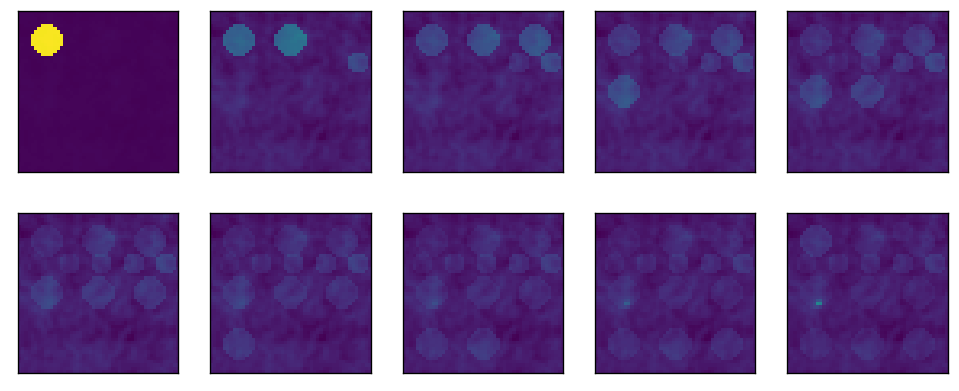

In [11]:
vmax = np.max(Tk_box_arr)

fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(Tk_box_arr[i*5+j][25], vmax=vmax)
        axs[i,j].set(xticks=[], yticks=[])

In [12]:
ionized_box = p21c.ionize_box(
    spin_temp = spin_temp,
)

The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The followin

## Archive

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
im0 = axs[0].imshow(input_heating.input_heating[25])
im1 = axs[1].imshow(input_ionization.input_ionization[25])

axs[0].set(title=r'input heating', xticks=[], yticks=[])
axs[1].set(title=r'input ionization', xticks=[], yticks=[])

#fig.colorbar(im0, ax=axs[0], orientation='horizontal')
#fig.colorbar(im1, ax=axs[1], orientation='horizontal')

[Text(0.5, 1.0, 'input ionization'), [], []]

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x155529fac200> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/TeX Live for SUSE Linux) (preloaded format=latex)
 restricted \write18 enabled.

kpathsea: Running mktexfmt latex.fmt
mktexfmt [ERROR]: -user mode but path setup is -sys type, bailing out.
I can't find the format file `latex.fmt'!




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/TeX Live for SUSE Linux) (preloaded format=latex)
 restricted \write18 enabled.

kpathsea: Running mktexfmt latex.fmt
mktexfmt [ERROR]: -user mode but path setup is -sys type, bailing out.
I can't find the format file `latex.fmt'!




<Figure size 960x480 with 2 Axes>

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
im0 = axs[0].imshow(spin_temp.Tk_box[25])
im1 = axs[1].imshow(spin_temp.x_e_box[25])

axs[0].set(title='spin_temp.Tk_box', xticks=[], yticks=[])
axs[1].set(title='spin_temp.x_e_box', xticks=[], yticks=[])

fig.colorbar(im0, ax=axs[0], orientation='horizontal')
fig.colorbar(im1, ax=axs[1], orientation='horizontal')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x155529fac200> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/TeX Live for SUSE Linux) (preloaded format=latex)
 restricted \write18 enabled.

kpathsea: Running mktexfmt latex.fmt
mktexfmt [ERROR]: -user mode but path setup is -sys type, bailing out.
I can't find the format file `latex.fmt'!




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/TeX Live for SUSE Linux) (preloaded format=latex)
 restricted \write18 enabled.

kpathsea: Running mktexfmt latex.fmt
mktexfmt [ERROR]: -user mode but path setup is -sys type, bailing out.
I can't find the format file `latex.fmt'!




<Figure size 1200x600 with 4 Axes>